In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
import glob
import pathlib
from tensorflow import keras

# Fonctions

In [ ]:
def dataset_2_numpy(test_ds) :
  imagess = np.empty((1,224,224,3),dtype='uint8')
  labels = np.array([])

  for image_batch, label_batch in test_ds:
    labels = np.append(labels, label_batch)
    imagess = np.concatenate((imagess,image_batch),axis = 0)
    print(labels.shape)
    print(imagess.shape)
    if imagess.shape[0] >7501 :
      break
  return labels,imagess

In [ ]:
def get_predictions(X_train,modeloo):
  predictions = modeloo.predict(X_train)
  predictions = np.array([np.argmax(i) for i in predictions])
  print(predictions.shape)
  return predictions

In [ ]:
def make_confusion_matrix(y_train,predictions):
  Ntrial = 0
  if Ntrial == 1 : 
    pass
  cm = tf.math.confusion_matrix(labels=y_train,predictions=predictions)
  import seaborn as sn
  plt.figure(figsize = (10,7))
  sn.heatmap(cm, annot=True, fmt='d')
  #plt.xticks([0,1,2],['Masque_Correct','Masque_Incorrect','Sans_Masque'])
  plt.xlabel('Predicted')
  plt.ylabel('Truth')

In [ ]:
def make_roc(y_train,predict):

  from sklearn.preprocessing import label_binarize
  #binarize the y_values

  y_test_binarized=label_binarize(y_train,classes=np.unique(y_train))
  predict_bin=label_binarize(predict,classes=np.unique(predict))
  # roc curve for classes
  fpr = {}
  tpr = {}
  thresh ={}
  roc_auc = dict()
  classes = ['Masque_Incorrect','Sans_Masque','Masque_Correct']
  n_class = len(classes)
  from sklearn.metrics import roc_curve,auc
  plt.figure(figsize=[15,14]) 
  for i in range(n_class):    
      fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], predict_bin[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      
      # plotting    
      plt.plot(fpr[i], tpr[i], 
              label='%s/Autres (AUC=%0.2f)'%(classes[i],roc_auc[i]))

  
  plt.xlim([0,1])
  plt.ylim([0,1.05])
  plt.title('Multiclasses Courbe ROC',fontsize = 18)
  plt.xlabel('Taux des Faux Positifs ',fontsize = 18)
  plt.ylabel('Taux des Vrais Positifs',fontsize = 18)
  plt.legend(loc='lower right',prop={"size":18})
  plt.show()

In [ ]:
def make_roc_class(y_train,predictions,class_index):

  from sklearn.preprocessing import label_binarize
  #binarize the y_values

  y_test_binarized=label_binarize(y_train,classes=np.unique(y_train))
  predictions_bin=label_binarize(predictions,classes=np.unique(predictions))
  # roc curve for classes
  fpr = {}
  tpr = {}
  thresh ={}
  roc_auc = dict()
  plt.figure(figsize=[15,14]) 
  n_class = len(class_names)
  classes = ['Masque_Incorrecte','Sans_Masque','Masque_Correct']
  from sklearn.metrics import roc_curve,auc

     
  fpr, tpr, thresh = roc_curve(y_test_binarized[:,class_index], predictions_bin[:,class_index])
  roc_auc = auc(fpr, tpr)
      
  # plotting    
  plt.plot(fpr, tpr, 
          label='%s / Autres (AUC=%0.2f)'%(classes[class_index],roc_auc))

  #plt.plot([0,1],[0,1],'b--')
  plt.xlim([0,1])
  plt.ylim([0,1.05])
  plt.title('Courbes ROC Des 3 classes Du modèle')
  plt.xlabel('Taux des Faux Positifs ')
  plt.ylabel('Taux des Vrais Positifs')
  plt.legend(loc='lower right')
  plt.show()

# importation et pretraitement de la base de donnée du test

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! ls ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
kaggle.json


In [ ]:
! kaggle datasets download -d spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask

 92% 175M/190M [00:01<00:00, 181MB/s]
100% 190M/190M [00:01<00:00, 151MB/s]


In [ ]:
! unzip face-mask-detectormask-not-mask-incorrect-mask.zip
! rm face-mask-detectormask-not-mask-incorrect-mask.zip

In [ ]:
! pip install mediapipe
! pip install cvzone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for cvzone: filename=cvzone-1.5.6-py3-none-any.whl size=18768 sha256=714d74e2782453261598a1a39580f0991b2ae147c6a70fa2197d89205331f068
  Stored in directory: /root/.cache/pip/wheels/c1/e8/e9/80f482161ba9f5dcf4832b76ac70540edd11a3136a58445c52
Successfully built cvzone


In [ ]:
! mkdir /content/dataset2
! mkdir /content/dataset2/incorrect_mask
! mkdir /content/dataset2/with_mask
! mkdir /content/dataset2/without_mask

In [ ]:
from cvzone.FaceDetectionModule import FaceDetector
import cv2
import glob

detector = FaceDetector()
path = glob.glob('/content/dataset/*')

for mask_path in path :
  j=0
  mask_path = glob.glob(mask_path+'/*')
  for img_path in mask_path:
    img = cv2.imread(img_path)
    img, bboxs = detector.findFaces(img,draw=False)
    for i in range(len(bboxs)):
        box = bboxs[i]['bbox']
        cr_img = img[   box[1]:box[1]+box[3]+10    ,  box[0]:box[0]+box[2] ]
                            #height                         #width
        
        if cr_img is None or box[0]-1 < 0 or box[1]-1 < 0 or box[0]+box[2] > img.shape[1] or box[1]+box[3] > img.shape[0]:
            continue
        else:
            cr_img = cv2.resize(cr_img, dsize=(224,224))
            path= '/content/dataset2/'+img_path.split('/')[3]+'/'+str(j)+'.jpg'
            print(cv2.imwrite(path,cr_img))
            print(cr_img.shape)
            j+=1
            

In [ ]:
path = glob.glob('/content/dataset/*')

for mask_path in path :
  mask_path = glob.glob(mask_path+'/*')
  for img_path in mask_path:
    print(img_path)
    break

/content/dataset/incorrect_mask/aug_650.jpg
/content/dataset/without_mask/augmented_image_319.jpg
/content/dataset/with_mask/331-with-mask.jpg


In [ ]:
print(len(glob.glob('/content/dataset2/incorrect_mask/*')))

623


In [ ]:
data_dir  = pathlib.Path('/content/dataset2/')

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 1978 files belonging to 3 classes.


In [ ]:
class_names = test_ds.class_names
print(class_names)

['incorrect_mask', 'with_mask', 'without_mask']


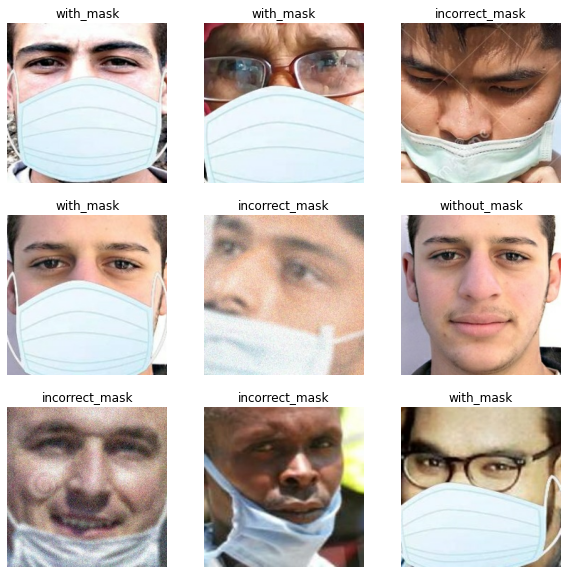

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Test Modele MobileNetV2

In [ ]:
new_model = tf.keras.models.load_model('/content/best_weights_SHOULD_BE_PRODUCTION_READY.h5')

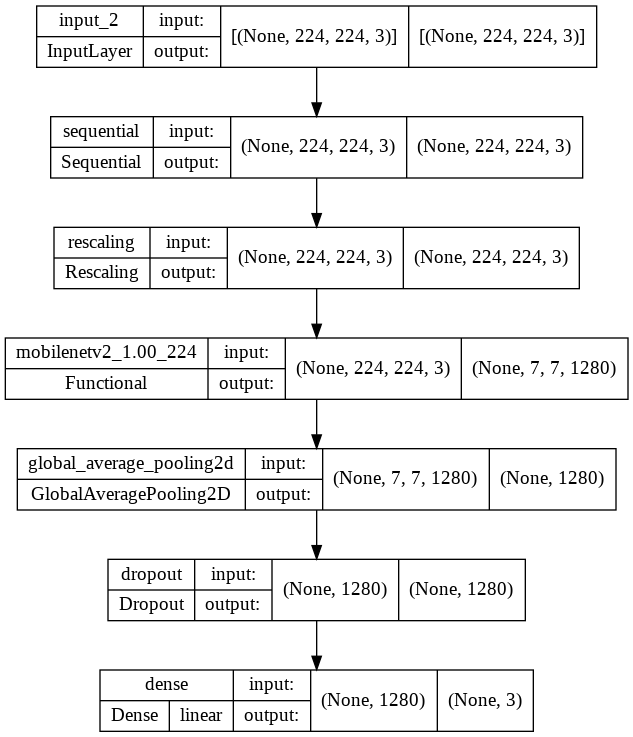

In [ ]:
tf.keras.utils.plot_model(new_model,show_shapes=True,show_layer_activations=True)

In [ ]:
labels,imagess = dataset_2_numpy(test_ds)

In [ ]:
imagess = imagess[1:]

In [ ]:
predictions = get_predictions(imagess,new_model)

(1978,)


In [ ]:
for i in range(len(predictions)):
  if predictions[i] == 1 :
    predictions[i] = 2
  elif predictions[i] == 2 :
    predictions[i] = 1

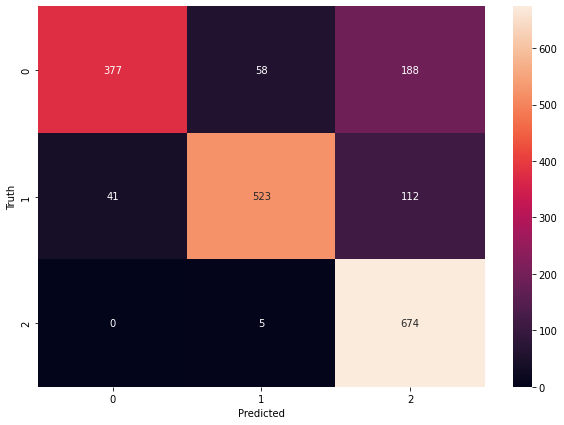

In [ ]:
make_confusion_matrix(labels,predictions)

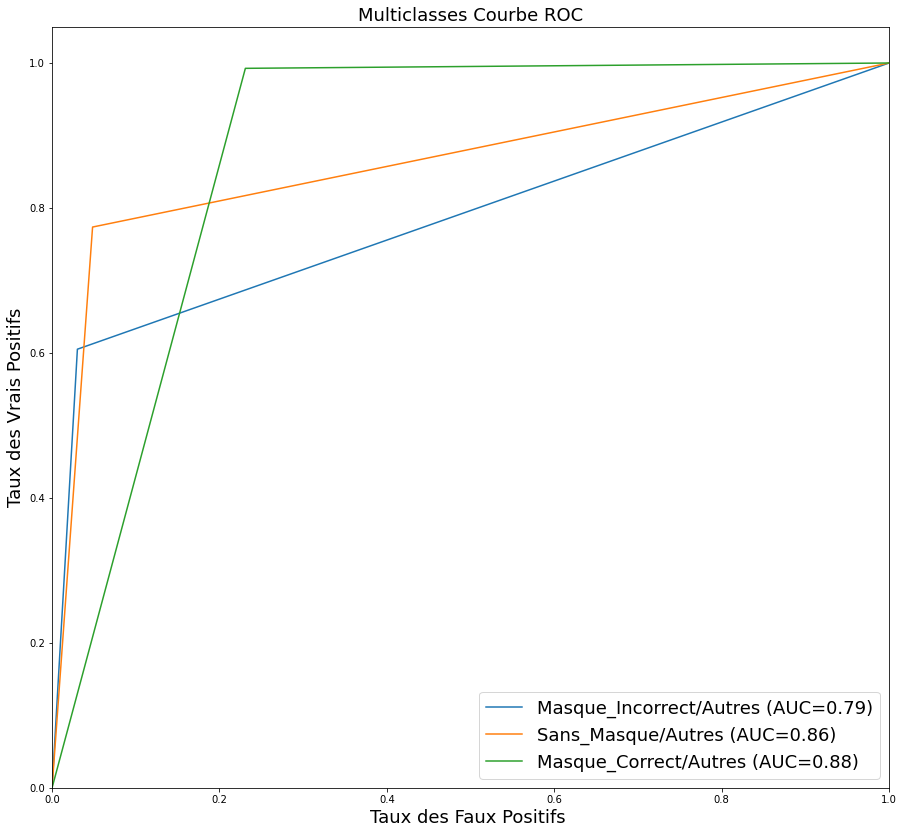

In [ ]:
make_roc(labels,predictions)

In [ ]:
predictions = np.array([])

# Test detection des pixels peau

In [ ]:
def skin_mask(cr_img,nose = False,mouth = False):
    min_YCrCb = np.array([0,135,58],np.uint8)
    max_YCrCb = np.array([255,180,135],np.uint8)
    min_HSV = np.array([0, 15, 0], dtype = "uint8")
    max_HSV = np.array([17, 150, 255], dtype = "uint8")

    if nose:
        crop = cr_img[  int(cr_img.shape[0]*(1/3)):int(cr_img.shape[0]*(2/3))-4  ,   20:int(cr_img.shape[1])-20]
    elif mouth:
        crop = cr_img[  int(cr_img.shape[0]*(2/3)):int(cr_img.shape[0])-4  ,   20:int(cr_img.shape[1])-20]
    else:
        crop = cr_img[  int(cr_img.shape[0]*(1/3)):int(cr_img.shape[0])-4  ,   20:int(cr_img.shape[1])-20]

    

    total_area = int(crop.shape[0])*int(crop.shape[1])
    imageHSV = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
    imageYCrCb = cv2.cvtColor(crop,cv2.COLOR_BGR2YCR_CB)
    Ycrcb_mask = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb) 
    hsv_mask = cv2.inRange(imageHSV, min_HSV, max_HSV)
    mask = cv2.bitwise_or(Ycrcb_mask,hsv_mask) 
    mask = cv2.medianBlur(mask,3)
    mask = cv2.erode(mask, np.ones((2,2), np.uint8))
    mask = cv2.dilate(mask, np.ones((1,1), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))
    count=np.count_nonzero(mask)

    return mask,total_area,count

In [ ]:
labels = np.array([])
path = glob.glob("/content/dataset2/*")
pred = np.array([])
for class_path in path:
  class_path = glob.glob(class_path+'/*')
  print(class_path)
  for img_p in class_path:
    print(img_p)
    img = cv2.imread(img_p)

    mask,total_area,count = skin_mask(img)
    if count/total_area <0.15:
        pred = np.append(pred,1) # masque correcte
    elif count/total_area > 0.9:
        pred = np.append(pred,2) # sans masque
    else :
      mask,total_area,count = skin_mask(img,nose=True)
   
      pourcentage = str(int((count/total_area)*100 ))
      if count/total_area > 0.3: 
        pred = np.append(pred,0) # masque incorrect
      else : 
        mask,total_area,count = skin_mask(img,mouth=True)
        if count/total_area < 0.4:
          pred = np.append(pred,1) # masque correcte  
        else:
          pred = np.append(pred,0) # masque incorrect
    if img_p.split('/')[3]=='incorrect_mask':
      labels = np.append(labels,0)
    elif img_p.split('/')[3]=='with_mask':
      labels = np.append(labels,1)
    elif img_p.split('/')[3]=='without_mask':
        labels = np.append(labels,2)
print(pred)
print(labels)

['/content/dataset2/with_mask/105.jpg', '/content/dataset2/with_mask/481.jpg', '/content/dataset2/with_mask/52.jpg', '/content/dataset2/with_mask/251.jpg', '/content/dataset2/with_mask/5.jpg', '/content/dataset2/with_mask/304.jpg', '/content/dataset2/with_mask/423.jpg', '/content/dataset2/with_mask/306.jpg', '/content/dataset2/with_mask/128.jpg', '/content/dataset2/with_mask/191.jpg', '/content/dataset2/with_mask/0.jpg', '/content/dataset2/with_mask/510.jpg', '/content/dataset2/with_mask/190.jpg', '/content/dataset2/with_mask/419.jpg', '/content/dataset2/with_mask/178.jpg', '/content/dataset2/with_mask/658.jpg', '/content/dataset2/with_mask/335.jpg', '/content/dataset2/with_mask/319.jpg', '/content/dataset2/with_mask/272.jpg', '/content/dataset2/with_mask/15.jpg', '/content/dataset2/with_mask/392.jpg', '/content/dataset2/with_mask/166.jpg', '/content/dataset2/with_mask/576.jpg', '/content/dataset2/with_mask/34.jpg', '/content/dataset2/with_mask/116.jpg', '/content/dataset2/with_mask/23

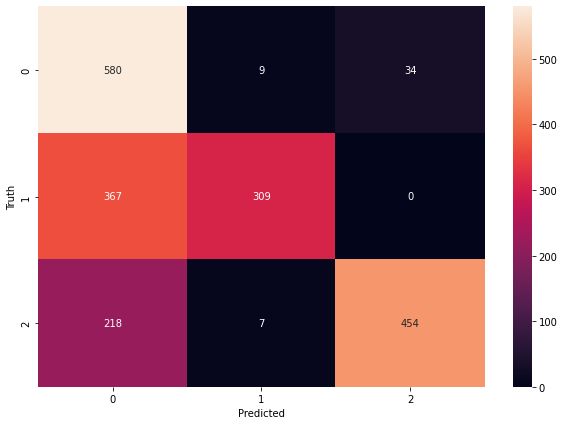

In [ ]:
make_confusion_matrix(labels,pred)

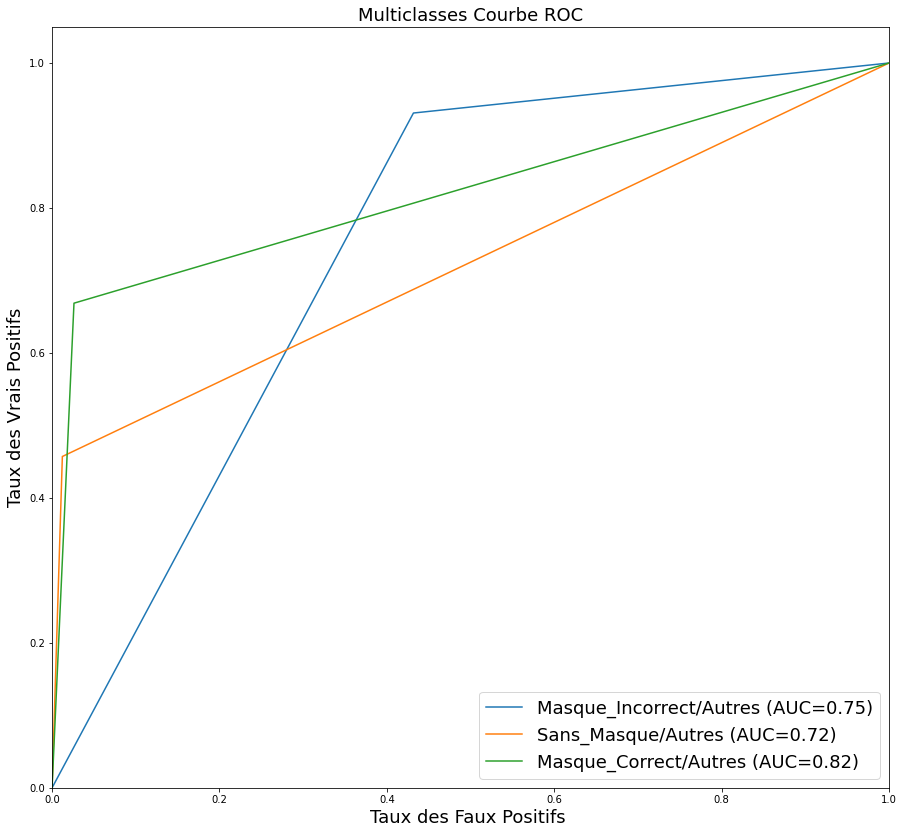

In [ ]:
make_roc(labels,pred)

# Test YOLO V5

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12229, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 12229 (delta 24), reused 28 (delta 14), pack-reused 12183
Receiving objects: 100% (12229/12229), 11.97 MiB | 30.79 MiB/s, done.
Resolving deltas: 100% (8460/8460), done.


In [ ]:
%cd yolov5/

/content/yolov5


In [ ]:
! pip install -r requirements.txt

In [ ]:
import torch
import glob

# Model
model = torch.hub.load('ultralytics/yolov5', 'custom', path ="/content/best.pt" , force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-6-11 Python-3.7.13 torch-1.11.0+cu113 CPU

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7251912 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
torch.cuda.empty_cache()
! nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# Images
s= np.array([])
imgs = glob.glob('/content/dataset/*')
for path in imgs: 
  img = glob.glob(path+'/*.jpg')[:100]
  results = model(img)
  #results.print()  # or .show(), .save()
  
  for i in results.pred:
    if len(i)>0:
      s = np.append(s,np.array(torch.Tensor.cpu(i[0][5])))
    else:
      s = np.append(s,0)
  print(s)

[          0           0           0           0           0           0           2           0           0           0           0           0           2           0           1           0           0           0           0           0           1           0           0           0           0           2
           1           0           0           1           0           1           0           1           0           0           1           0           0           1           0           2           0           0           0           0           2           0           0           1           0           2
           1           1           0           1           0           0           0           0           0           0           0           0           0           1           2           0           0           0           0           0           1           0           0           0           2           2
           0           0           0           0           1 

In [ ]:
for i in range(len(s)):
  if s[i] == 1 : #incorrect_masks (yolo)
    s[i] = 0  #incorret_masks (predictions)
  elif s[i] == 2 : #without mask
    s[i] = 1  #without mask 
  elif s[i] == 0 : #correct mask
    s[i] = 2

In [ ]:
truth = np.array([])
for i in range(10,len(s)+10,10):
  print(s[:i])
  if i <= len(s)/3: 
    truth = np.append(truth,np.array([2]*10)) 
  elif i <= 2*len(s)/3:
    truth = np.append(truth,np.array([1]*10))
  elif i <= len(s):
    truth = np.append(truth,np.array([0]*10))
  print(truth)

[          2           2           2           2           2           2           1           2           2           2]
[          2           2           2           2           2           2           2           2           2           2]
[          2           2           2           2           2           2           1           2           2           2           2           2           1           2           0           2           2           2           2           2]
[          2           2           2           2           2           2           2           2           2           2           2           2           2           2           2           2           2           2           2           2]
[          2           2           2           2           2           2           1           2           2           2           2           2           1           2           0           2           2           2           2           2           0           2        

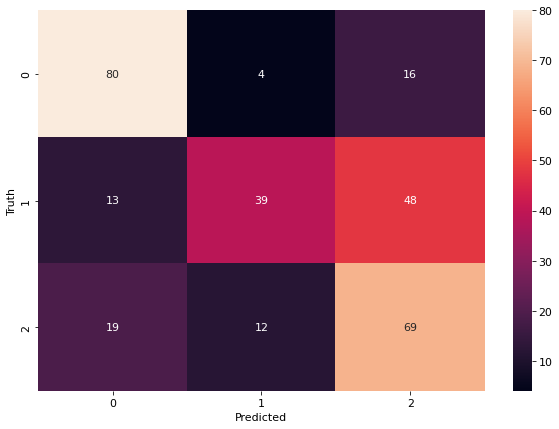

In [ ]:
make_confusion_matrix(truth,s)

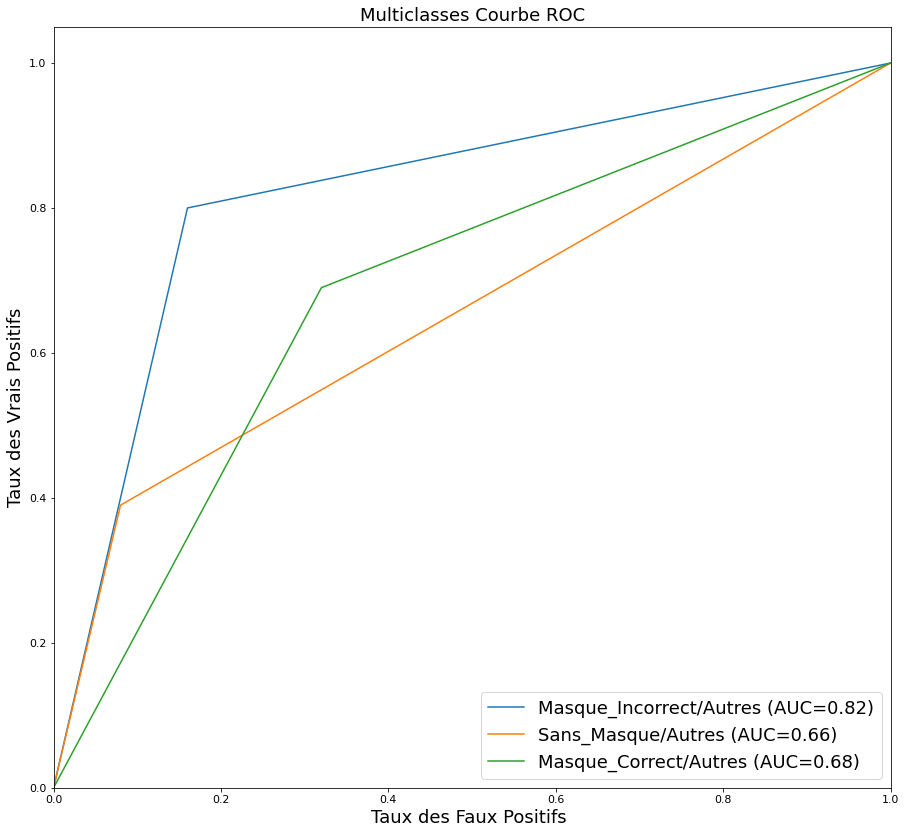

In [ ]:
make_roc(truth,s)

# Test images

In [ ]:
%cd ..

/content


In [ ]:
! unzip /content/image_showcase.zip

unzip:  cannot find or open /content/image_showcase.zip, /content/image_showcase.zip.zip or /content/image_showcase.zip.ZIP.


In [ ]:
testing_images_dir = glob.glob('image_showcase/variation_de_masque/')

In [ ]:
new_model = tf.keras.models.load_model('/content/best_weights_SHOULD_BE_PRODUCTION_READY.h5')

In [ ]:
def prediction_from_image(model_name,image):
  classes = ['Masque_Incorrect','Sans_Masque','Masque_Correct']
  if model_name == 'mobilenet':
    img0 = cv2.imread(image)
    img0 = cv2.resize(img0,(224,224))
    img0 = cv2.cvtColor(img0, cv2.COLOR_RGB2BGR)
    s = []
    s.append(img0)
    s = np.array(s)
    prediction = new_model.predict(s)
    prediction = np.argmax(prediction)
    return classes[prediction]


  elif model_name == 'skin':
    img = cv2.imread(image)
    prediction = np.array([])
    cropped_image = []
    crpd_img = np.array([])

    # detection du visage + dessin des rectangles sur l'image
    img, bboxs = detector.findFaces(img,draw=False) 
    #S'il y a des visages dans l'image
    if len(bboxs)>0: 

        for i in range(len(bboxs)): # pour chaque visages

            box = bboxs[i]['bbox']

            # prenant l'image recadré du visage
            cr_img = img[   box[1]-10:box[1]+box[3]+10  ,  box[0]:box[0]+box[2] ]
                                    #height                         #width

            # Verifier Si tous le visage est à l'intérieur de l'image
            if cr_img is None or box[0]-10 < 0 or box[1]-10 < 0 or box[0]+box[2] > img.shape[1] or box[1]+box[3] > img.shape[0]:
                continue
            else:
              img0 = cv2.resize(cr_img,(224,224))
              mask,total_area,count = skin_mask(img0)
              plt.imshow(mask)
              if count/total_area <0.3:

                  prediction = np.append(prediction,1) # masque correcte
              elif count/total_area > 0.9:
                  prediction = np.append(prediction,2) # sans masque
              else :

                mask,total_area,count = skin_mask(img0,nose=True)
                if count/total_area > 0.5: 
                  prediction = np.append(prediction,0) # masque incorrect
                  
                else : 
                  mask,total_area,count = skin_mask(img0,mouth=True)
                  if count/total_area < 0.6:
                    prediction = np.append(prediction,1) # masque correcte  
                  else:
                    prediction = np.append(prediction,0) # masque incorrect
            
            return classes[np.uint8(prediction[0])]

  elif model_name == 'yolo':
    # Images
      img = glob.glob(image)
      results = model(img)
      if len(results.pred)>0:
        prediction = np.array(torch.Tensor.cpu(results.pred[0][0][5]))
      else:
        print('no detection for '+ image)
  return classes[int(prediction)]

In [ ]:
#variation background 
var_path = glob.glob('/content/image_showcase/variation_de_visage/*')
for class_p in var_path : 
  class_p = glob.glob(class_p+'/*')
  for image_p in class_p:
    print(image_p)
    print('mobilenet:')
    print(prediction_from_image('mobilenet',image_p))
    print('skin_detection:')
    print(prediction_from_image('skin',image_p))
    print('yolo:')
    print(prediction_from_image('yolo',image_p))
  plt.imshow(cv2.cvtColor(cv2.imread(image_p),cv2.COLOR_BGR2RGB))